# Simple Neural Network

In [1]:
# Import necessary packages

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt

from utils import load_posistions, load_data

## Data preparation
1. Create dataset class
2. Vectorize CSI to use it as input
3. Create loader to iterate over the dataset

### Dataset

In [2]:
class CSIDataset(Dataset):
    """CSI dataset."""
    
    def __init__(self, positions_file, samples_dir, indices_file):
        """
        Args:
            positions_file (string): Path to the file containing the user positions.
            samples_dir (string): Directory containing the samples.
            indexes_file (string): Path to the file holding the indexes to be considered for the set
        """
        self.user_positions = load_data(positions_file)
        self.samples_dir = samples_dir
        self.indices = load_data(indices_file)
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        index = self.indices[idx]
        
        sample_filepath = os.path.join(self.samples_dir, 'channel_measurement_{:06d}.npy'.format(index))
        sample = load_data(sample_filepath)
                    
        # Remove z coordinate from the positions
        label = np.delete(self.user_positions[index], -1)
        
        return sample, label

### Vectorize sample
Each sample $\hat h\in\mathbb{C}^{64\times100}$ for the 64 antennas and 100 subcarriers. <br>
Since each sample is a complex matrix, it is necessary to vectorize it to use it as input for the neural network. This is done first by concatenating the CSI values of each antenna into a vector:
$$
\textbf{h}_k=\begin{bmatrix}
h_{k,1}\\
h_{k,2}\\
\vdots\\
h_{k,100}
\end{bmatrix} \text{ for } k\in\{1,...,64\}
$$
Then concatenating each $\textbf{h}_k$ into a vector of size 6400:
$$
\hat{\textbf{h}}=\begin{bmatrix}
\textbf{h}_1\\
\textbf{h}_2\\
\vdots\\
\textbf{h}_{64}
\end{bmatrix}=\begin{bmatrix}
h_{1,1}\\
\vdots\\
h_{1,100}\\
h_{2,1}\\
\vdots\\
h_{2,100}\\
\vdots\\
h_{64,1}\\
\vdots\\
h_{64,100}
\end{bmatrix}
$$
Finally, since Pytorch cannot handle complex numbers, it is necessary to tranform each CSI value $h$ into $h' =\begin{bmatrix}real(h)\\ imag(h)\end{bmatrix}$. <br>
Thus, the final vector $\hat{\textbf h}$ is:
$$
\hat{\textbf h}=
\begin{bmatrix}
real(h_{1,1})\\
imag(h_{1,1})\\
\vdots\\
real(h_{1,100})\\
imag(h_{1,100})\\
real(h_{2,1})\\
imag(h_{2,1})\\
\vdots\\
real(h_{2,100})\\
imag(h_{2,100})\\
\vdots\\
real(h_{64,1})\\
imag(h_{64,1})\\
\vdots\\
real(h_{64,100})\\
imag(h_{64,100})
\end{bmatrix},
$$
which is a $12800\times1$ vector.

In [3]:
def vectorize_samples(samples):
    # concatenate into one 6400x1 vector
    samples = torch.flatten(samples, start_dim=1)
    # split complex values
    samples = torch.stack((samples.real, samples.imag), -1) # vector is now 6400x2
    # concatenate into one 12800x1 vector
    samples = torch.flatten(samples, start_dim=1)
    return samples

In [4]:
train_dataset = CSIDataset(
    '/mnt/d/mathe/Documents/thesis/ultra_dense/DIS_lab_LoS/user_positions.npy',
    '/mnt/d/mathe/Documents/thesis/ultra_dense/DIS_lab_LoS/samples',
    '/mnt/d/mathe/Documents/thesis/ultra_dense/DIS_lab_LoS/train_indices.npy'
)
test_dataset = CSIDataset(
    '/mnt/d/mathe/Documents/thesis/ultra_dense/DIS_lab_LoS/user_positions.npy',
    '/mnt/d/mathe/Documents/thesis/ultra_dense/DIS_lab_LoS/samples',
    '/mnt/d/mathe/Documents/thesis/ultra_dense/DIS_lab_LoS/test_indices.npy'
)
print(
    f'Dataset size: {len(train_dataset) + len(test_dataset)}\n'
    f'Training set size: {len(train_dataset)}\n'
    f'Test set size: {len(test_dataset)}'
)

Dataset size: 252004
Training set size: 201568
Test set size: 50436


### Dataloader
Dataloader allows for some useful features when iterating over the dataset [\[1\]](#1), such as
* Batching the data
* Shuffling the data
* Loading the data in parallel using multiprocessing workers

In [5]:
batch_size = 64
num_workers = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

## Neural network model

In [6]:
from torch import nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Input layer
        self.fc1 = nn.Linear(12800, 16000)
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 4, kernel_size=4, stride=4)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=(4,2), stride=(4,2)) 
        self.conv3 = nn.Conv2d(8, 20, kernel_size=(1,5), stride=(1,5)) 
        self.fc2 = nn.Linear(500, 2)
        
    def forward(self, x):

        # First layer (fully connected)
        x = self.fc1(x) # shape: 16000
        x = F.relu(x)
        
        # Reshape x to pass it through convolutional layers
        x = x.reshape((-1, 1, 80, 200)) # shape: 1 x 80 x 200

        x = self.conv1(x) # shape: 4 x 20 x 50 = 4000
        # x = F.max_pool2d(x, kernel_size=(4,4)) # 4 x 20 x 50 = 4000
        x = F.relu(x) # 4 x 20 x 50 = 4000
        # print(f'Shape 1: {x.shape}')
        
        x = self.conv2(x) # shape: 8 x 5 x 25 = 
        # x = F.max_pool2d(x, kernel_size=2) # 8 x 10 x 25 = 1000
        x = F.relu(x) # 8 x 10 x 25
        # print(f'Shape 2: {x.shape}')
        
        x = self.conv3(x) # 20 x 5 x 5
        # x = F.max_pool2d(x, kernel_size=(5,5)) # 16 x 1 x 5 = 80
        x = F.relu(x) # 20 x 5 x 5 = 500
        # print(f'Shape 3: {x.shape}')
        
        # Flatten to run through last layer
        x = torch.flatten(x, 1) # shape: 500
        # print(f'Shape 4: {x.shape}')
        
        # Output layer
        x = self.fc2(x)
        
        return x

In [7]:
model = Network()
model

Network(
  (fc1): Linear(in_features=12800, out_features=16000, bias=True)
  (conv1): Conv2d(1, 4, kernel_size=(4, 4), stride=(4, 4))
  (conv2): Conv2d(4, 8, kernel_size=(4, 2), stride=(4, 2))
  (conv3): Conv2d(8, 20, kernel_size=(1, 5), stride=(1, 5))
  (fc2): Linear(in_features=500, out_features=2, bias=True)
)

## Training the model

In [8]:
from torch import optim

# Choose GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
model.to(device)
device.type

'cpu'

In [9]:
# Define the loss as MSE loss
criterion = nn.MSELoss()
# Define optimizer to update weights (stochastic gradient descent)
optimizer = optim.SGD(model.parameters(), lr=0.001)

import time
start = time.time()

epochs = 100
training_losses = []
testing_losses = []
for e in range(epochs):
    training_loss = 0
    testing_loss = 0
    for samples, labels in train_loader:
        
        samples, labels = samples.to(device), labels.to(device)
        
        # Vectorize the samples
        samples = vectorize_samples(samples)
    
        optimizer.zero_grad()
        
        output = model(samples.float())
        loss = criterion(output, labels.float())
        loss.backward()
        
        # Clip gradients to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        
        training_loss += loss.item()
        #print(loss.item())
    else:
        with torch.no_grad():
            for samples, labels in test_loader:
                samples, labels = samples.to(device), labels.to(device)
        
                # Vectorize the samples
                samples = vectorize_samples(samples)

                output = model(samples.float())
                loss = criterion(output, labels.float())

                testing_loss += loss.item()
                
        training_loss /= len(train_dataset)
        testing_loss /= len(test_dataset)
        training_losses.append(training_loss)
        testing_losses.append(testing_loss)

        now = time.time()
        print("Epoch: {}/{}... ".format(e+1, epochs),
              "Training Loss: {:.3f}... ".format(training_loss),
              "Test Loss: {:.3f}... ".format(testing_loss),
              "Elapsed time: {}".format(now - start))
        



Epoch: 1/100...  Training Loss: 15626.967...  Test Loss: 2887.307...  Elapsed time: 5551.155955076218


RuntimeError: [enforce fail at CPUAllocator.cpp:67] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 819200000 bytes. Error code 12 (Cannot allocate memory)

## Test the model

KeyboardInterrupt: 

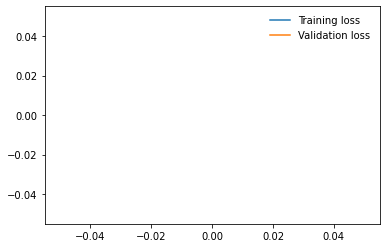

In [ ]:
plt.plot(training_losses, label='Training loss')
plt.plot(testing_losses, label='Validation loss')
plt.legend(frameon=False)

### Save the model

In [ ]:
torch.save(model.state_dict(), 'simple_nn')

## References
<a id='1'>\[1\]</a> https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html (29.04.2021)